<font color="#CA3532"><h1 align="left">**Máster en Big Data y Data Science - Fundamentos de Análisis de Datos**</h1></font>
## **PCA en imágenes faciales**

#### Manuel Sánchez-Montañés

In [0]:
COLAB = True

La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

%matplotlib inline

In [3]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='12tXWYS0UvaWByHgucI-APr7i2i4Rzkkg',
                                        dest_path="./caras_aux.py")
    gdd.download_file_from_google_drive(file_id='1N1TXs4XYSZgO1Wp0FYOMbLMW1sRrOukw',
                                        dest_path="./datasets/gender.zip",
                                        unzip=True)

Unzipping...Done.



Estadísticas básicas de la base de datos leída:
  # clases: 2
  # patrones: 2000
  # atributos (features): 2500

Algunas imágenes de la clase "female":


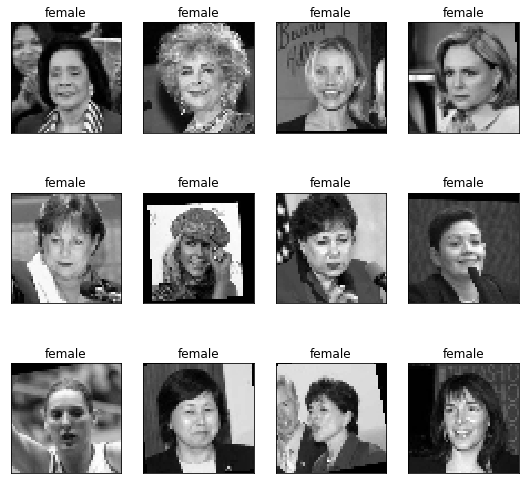


Algunas imágenes de la clase "male":


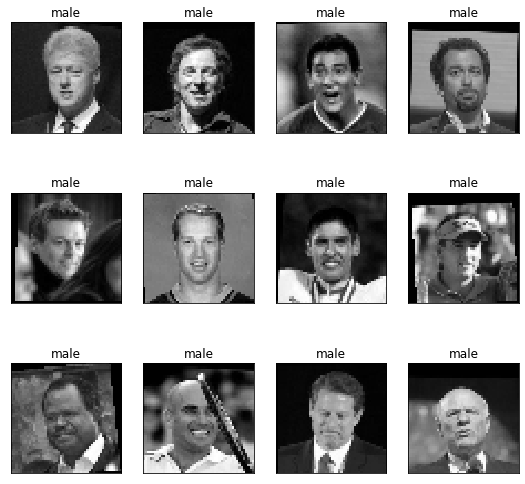

In [8]:
from caras_aux import loadImages, plot_gallery

# cargo las imágenes y preparo los datos que se van a usar
factor = 0.2 # factor de reducción de resolución de las imágenes, debe ser
             # >0 y <=1 (en cuyo caso la resolución es la original, 250x250)
X_clase0, h, w = loadImages('./datasets/gender/female',
                            factor=factor, nimages=1000)
X_clase1, h, w = loadImages('./datasets/gender/male',
                            factor=factor, nimages=1000)
X = np.concatenate((X_clase0, X_clase1))
n_samples, n_features = X.shape

target_names = np.array(['female', 'male'])
n_classes = len(target_names)
N0 = len(X_clase0); N1 = len(X_clase1)
y = N0*[0] + N1*[1]

print('\nEstadísticas básicas de la base de datos leída:')
print('  # clases: %d' % n_classes)
print('  # patrones: %d' % n_samples)
print('  # atributos (features): %d' % n_features)

print('\nAlgunas imágenes de la clase "female":')
plot_gallery(X_clase0[:12].reshape((12, h, w)), 12*['female'], cmap=plt.cm.gray)
print('\nAlgunas imágenes de la clase "male":')
plot_gallery(X_clase1[:12].reshape((12, h, w)), 12*['male'], cmap=plt.cm.gray)

In [9]:
print(np.shape(X)); print(np.shape(y)); print(X)

(2000, 2500)
(2000,)
[[ 18.  11.  10. ...  63.  59.  50.]
 [  1.   2.   3. ... 119.  28.  22.]
 [ 82.  42.  46. ...   0.   0.   1.]
 ...
 [ 38.  39.  54. ...  15.  12.  10.]
 [ 85.  85.  86. ...  67.  63.  55.]
 [163. 200. 232. ... 114. 237. 251.]]


## **Análisis de Componentes Principales (PCA)**


Calculando las primeras 1500 componentes principales ("autocaras") con el conjunto de training


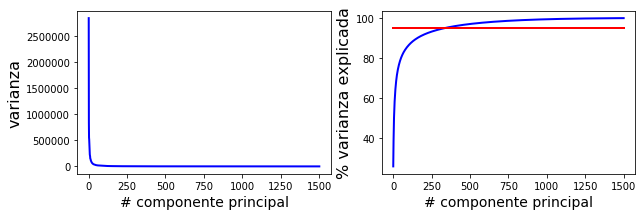

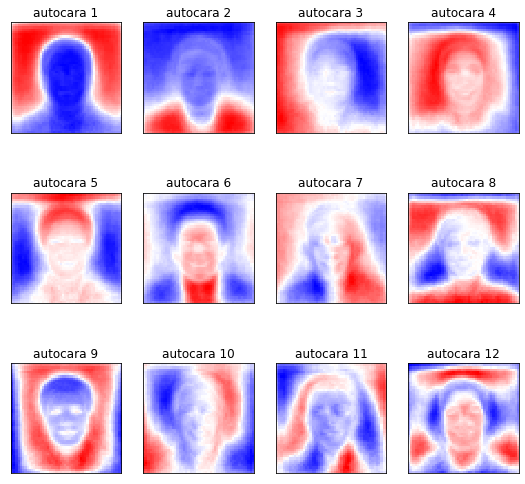

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# divido en conjuntos de training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)

n_componentes_principales = 1500 # numero de componentes que se usarán en PCA

pca = PCA(n_components=n_componentes_principales)
#pca = PCA(n_components=n_componentes_principales, whiten=True)

print('\nCalculando las primeras %d componentes principales ("autocaras") con el conjunto de training'
      % n_componentes_principales)

# *************************************************************************
# En caso de que queramos estandarizar las variables antes de realizar PCA:
#
# std_scaler = StandardScaler()
# std_scaler.fit(X_train)   # Forma INCORRECTA: std_scaler.fit(X)
# X_train = std_scaler.transform(X_train)
# X_test = std_scaler.transform(X_test)
#
# *************************************************************************

pca.fit(X_train)

autovectores = pca.components_
autocaras = autovectores.reshape((n_componentes_principales, h, w))

fig = plt.figure(figsize = (10,3))
ax1 = plt.subplot(1,2,1)
plt.plot(np.arange(1,n_componentes_principales+1), pca.explained_variance_, 'b', lw=2)
plt.xlabel('# componente principal',fontsize=14); plt.ylabel('varianza',fontsize=16)

ax2 = plt.subplot(1,2,2)
plt.plot(np.arange(1,n_componentes_principales+1), 100*pca.explained_variance_ratio_.cumsum(), 'b', lw=2)
percent_target = 95
plt.plot([0,n_componentes_principales], [percent_target,percent_target], 'r', lw=2)
plt.xlabel('# componente principal',fontsize=14); plt.ylabel('% varianza explicada',fontsize=16)

titulos_autocaras = ["autocara %d" % (i+1) for i in range(autocaras.shape[0])]
plot_gallery(autocaras, titulos_autocaras, cmap=plt.cm.bwr)
plt.show()

In [0]:
# Ahora proyecto las bases de datos de training y test sobre los autovectores,
# obteniendo las nuevas variables
X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)

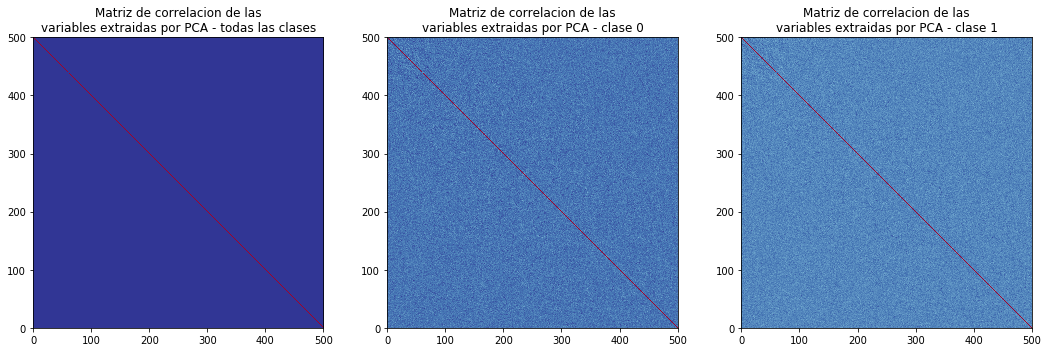

In [12]:
# Correlación entre las nuevas variables (clases mezcladas)
plt.figure(figsize=(15,5))
sm.graphics.plot_corr(np.corrcoef(X_train_pca, rowvar=0),
                      ax=plt.subplot(1,3,1),
                      title='Matriz de correlacion de las\nvariables extraidas por PCA - todas las clases')

# Correlación entre las nuevas variables (cada clase por separado)
sm.graphics.plot_corr(np.corrcoef(X_train_pca[np.where(np.array(y_train)==0)[0],:], rowvar=0),
                      ax=plt.subplot(1,3,2),
                      title='Matriz de correlacion de las\nvariables extraidas por PCA - clase 0')
sm.graphics.plot_corr(np.corrcoef(X_train_pca[np.where(np.array(y_train)==1)[0],:], rowvar=0),
                      ax=plt.subplot(1,3,3),
                      title='Matriz de correlacion de las\nvariables extraidas por PCA - clase 1');

In [19]:
print(np.shape(pca.components_))
print(np.shape(X_train_pca))

(1500, 2500)
(1800, 1500)


## **Reconstrucción de las caras usando un subconjunto de autocaras**


Dimensiones matriz autovectores:     (1500,2500)
Dimensiones matriz X_train:          (1800,2500)
Dimensiones matriz aux:              (1800,20)
Dimensiones matriz X_train_reconstr: (1800,2500)

Imagenes originales:


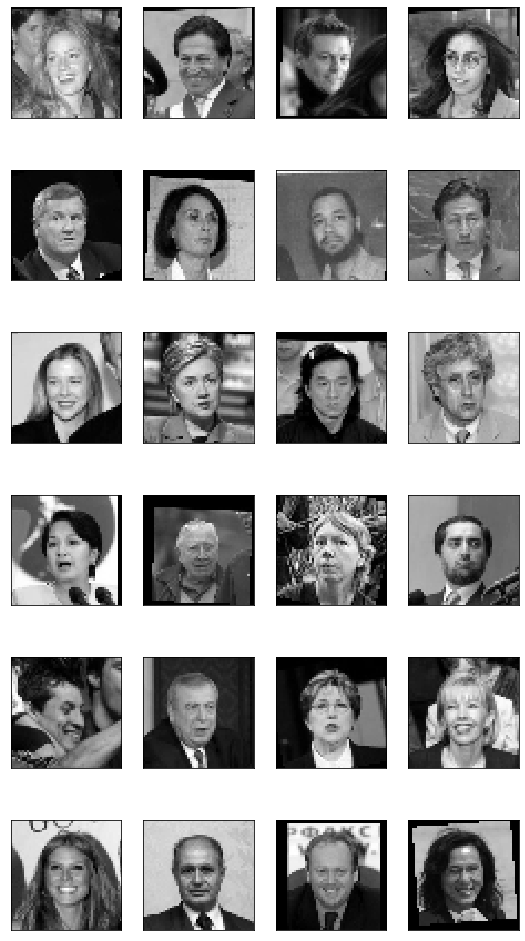


Imagenes reconstruidas con un subconjunto de autocaras:


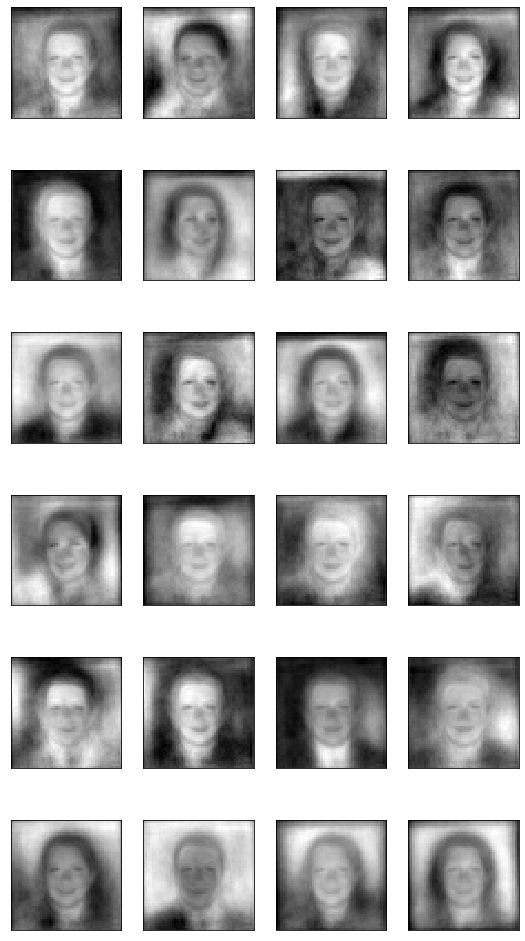

In [21]:
# Ahora represento la reconstruccion de las caras usando un subconjunto
# de componentes principales

#autocaras_usadas = [0,1,2,3,4,5]
#autocaras_usadas = np.arange(100,1500)
#autocaras_usadas = [0,1,2]
#autocaras_usadas = np.arange(20,1500)
autocaras_usadas = range(20)

print('\nDimensiones matriz autovectores:     (%d,%d)' % np.shape(autovectores))
print('Dimensiones matriz X_train:          (%d,%d)' % np.shape(X_train))
aux = np.matrix(X_train)*np.matrix(autovectores[autocaras_usadas,:]).T
print('Dimensiones matriz aux:              (%d,%d)' % np.shape(aux))
X_train_reconstr = np.array(aux*autovectores[autocaras_usadas,:])
print('Dimensiones matriz X_train_reconstr: (%d,%d)' % np.shape(X_train_reconstr))

primera_cara = 48
ncaras = 24
print('\nImagenes originales:')
inds_caras = np.arange(primera_cara, primera_cara+ncaras)
plot_gallery(X_train[inds_caras,:].reshape((len(inds_caras),h,w)), ncaras*[""],
             nrows=ncaras//4, ncols=4, cmap=plt.cm.gray)

print('\nImagenes reconstruidas con un subconjunto de autocaras:')
plot_gallery(X_train_reconstr[inds_caras,:].reshape((len(inds_caras),h,w)), ncaras*[""],
             nrows=ncaras//4, ncols=4, cmap=plt.cm.gray)

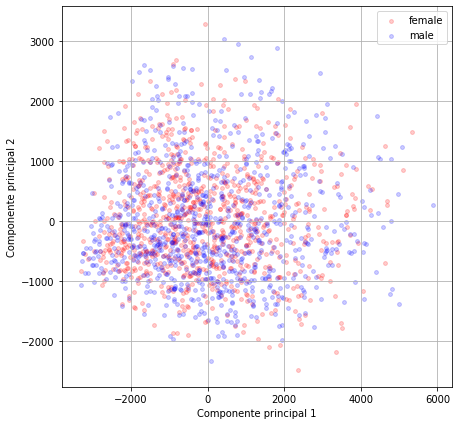

In [22]:
# Representación de la base de datos en el espacio 2D formado por dos componentes principales
componente_x = 0
componente_y = 1
colors  = ['r', 'b', 'g', 'y', 'm', 'k', 'r']
markers = ['.', '.', 'd', 'x', 'o', 'd', 'o']

plt.figure(figsize=(7, 7))
for clase,col,m in zip(np.unique(y),colors,markers):
    inds = np.where(y_train == clase)[0]
    plt.scatter(X_train_pca[inds, componente_x],
                X_train_pca[inds, componente_y],
                s=60,
                c=col, marker=m, alpha=0.2,
                label=target_names[clase])
plt.xlabel('Componente principal %d' % (componente_x+1))
plt.ylabel('Componente principal %d' % (componente_y+1))
plt.legend()
plt.grid();

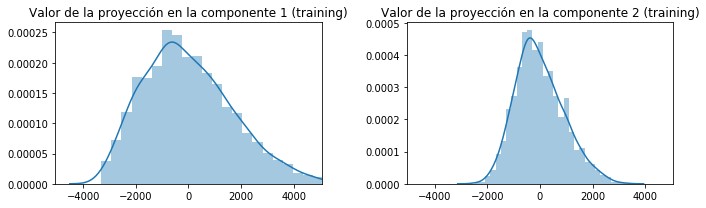

In [23]:
# Histogramas de los valores de las dos componentes principales consideradas

import seaborn as sns
# Nota: la librería seaborn no está incluida en la distribución Anaconda.
# Para instalarla, ejecutar en un terminal "pip install seaborn"
# Para más información:
# http://seaborn.pydata.org/installing.html

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
aux = X_train_pca[:,componente_x]
sns.distplot(aux, kde=True)
lims = [np.mean(aux)-3*np.std(aux), np.mean(aux)+3*np.std(aux)]
plt.title('Valor de la proyección en la componente %d (training)' % (componente_x+1))
plt.xlim(lims)

plt.subplot(1,2,2)
aux = X_train_pca[:,componente_y]
sns.distplot(aux, kde=True)
plt.title('Valor de la proyección en la componente %d (training)' % (componente_y+1))
plt.xlim(lims); plt.tight_layout(); plt.show()

## **Generación de caras nuevas**

In [24]:
print(np.shape(autocaras)); print(h)

(1500, 50, 50)
50



Imágenes generadas sintéticamente a partir de las autocaras:


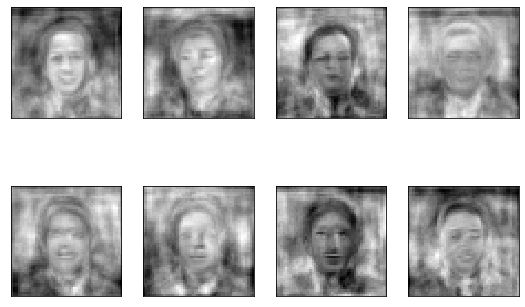

In [25]:
n_caras_sinteticas = 8
n_autocaras = 300
media = np.mean(X_train,axis=0).reshape((h,w))

caras_sinteticas = np.zeros((n_caras_sinteticas, h, w))
for i in range(n_caras_sinteticas):
    caras_sinteticas[i,:,:] = media
    for j in range(n_autocaras):
        caras_sinteticas[i,:,:] += np.random.randn()*np.sqrt(pca.explained_variance_[j])*autocaras[j,:,:]

caras_sinteticas = np.array(caras_sinteticas)
print('\nImágenes generadas sintéticamente a partir de las autocaras:')
plot_gallery(caras_sinteticas, n_caras_sinteticas*[""],
             nrows=n_caras_sinteticas//4, ncols=4, cmap=plt.cm.gray)